In [1]:
#!pip install numpy scipy matplotlib seaborn scikit-learn mesa==3.0 -q

In [2]:
# Requiero Mesa > 3.0.3
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
from mesa import Agent, Model

# Debido a que puede existir más de un solo agente por celda, haremos uso de ''MultiGrid''.
from mesa.space import MultiGrid

# Con 'BaseScheduler', los agentes se activan de forma secuencial en el orden que fueron agregados.
from mesa.time import BaseScheduler

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


/Users/carlos/Documents/GitHub/TacoRescue_TC2008B/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class TacoRescueAgent(Agent):
  def __init__(self, model):
    super().__init__(model)
    self.AP = 0
    self.carrying_victim = False

  def refill_ap(self):
    self.AP += 4
    if self.AP > 8:
      self.AP = 8

  def can_spend(self, cost):
    return self.AP >= cost

  def spend_AP(self, cost):
    if self.AP >= cost:
      self.AP -= cost
      print(cost, self.AP)
      return True
    return False

  def space_state(self, pos):
    # 0: Vacío | 1 = Humo | 2 = Fuego
    x, y = pos
    return int(self.model.fire[x][y])

  def remove_smoke(self, pos):
    # Quitar humo: 1AP
    if self.space_state(pos) != 1:
      return False

    if self.spend_AP(1):
      x, y = pos
      self.model.fire[x][y] = 0
      return True

    return False

  def extinguish_fire(self, pos):
    if self.space_state(pos) != 2:
      return False

    if self.spend_AP(2):
      x, y = pos
      self.model.fire[x][y] = 0
      return True
    return False

  def fire_to_smoke(self, pos):
    if self.space_state(pos) != 2:
      return False

    if self.spend_AP(1):
      x, y = pos
      self.model.fire[x][y] = 1
      return True
    return False

  def pick_up_victim(self, pos):
    if self.carrying_victim:
      return False

    if self.model.poi[pos] != 1:
      return False

    if self.model.poi[pos] == 1 and self.space_state(self.pos) != 2:
      self.carrying_victim = True
      self.model.poi[pos] = 0
      self.model.poi_unknown.remove(pos)
      self.model.victims_on_board += 1
      return True

    return False

  def drop_off_victim(self, pos):
    if not self.carrying_victim:
      return False

    if pos in self.model.entries and self.space_state(self.pos) != 2:
      self.carrying_victim = False
      self.model.rescued_count += 1
      self.model.victims_on_board -= 1
      return True

    return False

  def is_door_between(self, target_pos):
    return (self.pos in self.model.doors and self.model.doors[self.pos] == target_pos)

  def is_door_closed(self, target_pos):
    if not self.is_door_between(target_pos):
      return False

    x1, y1 = self.pos
    x2, y2 = target_pos
    dx, dy = x2 - x1, y2 - y1

    if dx == 1:
      wall = 1
    elif dx == -1:
      wall = 3
    elif dy == 1:
      wall = 0
    elif dy == -1:
      wall = 2
    else:
      return False

    return self.model.walls[y1][x1][wall] == 1

  def is_wall_between(self, pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    dx, dy = x2 - x1, y2 - y1

    if dx == 1:
      wall = 1
    elif dx == -1:
      wall = 3
    elif dy == 1:
      wall = 0
    elif dy == -1:
      wall = 2
    else:
      return False

    return self.model.walls[y1][x1][wall] == 1

  def open_door(self, target_pos):
    if not self.is_door_between(target_pos):
      return

    x1, y1 = self.pos
    x2, y2 = target_pos
    dx, dy = x2 - x1, y2 - y1

    if dx == 1:
      wall = 1
      opp = 3
    elif dx == -1:
      wall = 3
      opp = 1
    elif dy == 1:
      wall = 0
      opp = 2
    elif dy == -1:
      wall = 2
      opp = 0
    else:
      return

    self.model.walls[y1][x1][wall] = 0
    self.model.walls[y2][x2][opp] = 0

  def damage_wall(self, pos1, pos2):
    if not self.is_wall_between(pos1, pos2):
      return
    x1, y1 = pos1
    x2, y2 = pos2
    dx, dy = x2 - x1, y2 - y1

    if dx == 1:
      wall = 1
      opp = 3
    elif dx == -1:
      wall = 3
      opp = 1
    elif dy == 1:
      wall = 0
      opp = 2
    elif dy == -1:
      wall = 2
      opp = 0
    else:
      return

    # Si es una pared: acumula daño (2 golpes -> se destruye)
    if self.model.walls[y1][x1][wall] == 1:
      self.model.walls_damage[x1][y1][wall] += 1
      self.model.damage += 1
      if self.model.walls_damage[x1][y1][wall] == 2:
        self.model.walls[y1][x1][wall] = 0

    # También daña la pared opuesta en la celda vecina
    if 0 <= x2 < self.model.grid.width and 0 <= y2 < self.model.grid.height:
      if self.model.walls[y2][x2][opp] == 1:
        self.model.walls_damage[x2][y2][opp] += 1
        if self.model.walls_damage[x2][y2][opp] >= 2:
          self.model.walls[y2][x2][opp] = 0

  # Para cacular el costo según las reglas
  def calculate_cost(self, target_pos):
    spaceState = self.space_state(target_pos)
    if self.carrying_victim:
      # Fuego
      if spaceState == 2:
        return None
      return 2
    else:
      # Fuego
      if spaceState == 2:
        return 2
      # Vacío o con humo
      return 1

  def try_move(self, target_pos):
    cost = self.calculate_cost(target_pos)
    # Al fuego cuando el agente tenga víctima cargada
    if cost is None:
      return False

    spaceState = self.space_state(target_pos)
    # Si es fuego
    if spaceState == 2:
      # El agente debe tener al menos 1 AP
      # Para poder convertirlo en humo
      if self.AP < cost + 1:
        return False

    # Puertas
    if self.is_door_between(target_pos):
      if self.is_door_closed(target_pos):
        if self.can_spend(1):
          self.open_door(target_pos)
          self.spend_AP(1)
        return False

    # Paredes
    if self.is_wall_between(self.pos, target_pos):
      if self.can_spend(2):
        self.damage_wall(self.pos, target_pos)
        self.spend_AP(2)
      # El agente todavía no se mueve
      return False

    if not self.can_spend(cost):
      return False

    self.spend_AP(cost)

    # Si no tiene restricciones, mueve hacia al target posición
    self.model.grid.move_agent(self, target_pos)

    return True

  # Busca la entrada cercana
  def nearest_entry(self):
    x, y = self.pos
    best = None
    best_dis = None
    for ix, iy in self.model.entries:
      d = abs(ix - x) + abs(iy - y)
      if best is None or d < best_dis:
        best = (ix, iy)
        best_dis = d
    return best

  # Checa si está en una entrada
  def is_entry(self):
    x, y = self.pos
    best = None
    best_dis = None
    for ix, iy in self.model.entries:
      d = abs(ix - x) + abs(iy - y)
      if best is None or d < best_dis:
        best = (ix, iy)
        best_dis = d
    if best_dis == 0:
      return True
    return False

  def knock_out(self):
    if self.carrying_victim == True:
      self.carrying_victim = False
      self.model.lost_victims += 1
      self.model.victims_on_board -= 1
    self.model.grid.move_agent(self, self.nearest_entry())
    return True

  def step(self):
    # += 4AP
    self.refill_ap()

    if self.model.poi[self.pos] == 1:
      if not self.carrying_victim:
        self.pick_up_victim(self.pos)


    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    idxs = np.random.choice(len(directions), size=8, replace=True)
    options = [directions[i] for i in idxs]

    for dx, dy in options:
        if self.AP == 0:
          break

        x, y = self.pos
        pos = (x + dx, y + dy)

        print(self.pos, pos)
        if not (0 <= pos[0] < self.model.grid.width and 0 <= pos[1] < self.model.grid.height):
          continue


        state = self.space_state(pos)



        if not self.try_move(pos):
          continue

        if state == 2:
          if self.can_spend(2):
            self.extinguish_fire(pos)
          else:
            self.fire_to_smoke(pos)
        elif state == 1:
          if self.can_spend(1):
            self.remove_smoke(pos)
        elif state == 0:
          if self.model.poi[pos] == 1:
            self.pick_up_victim(pos)
          if self.model.poi[pos] == 2:
            self.model.poi[pos] = 0
            self.model.poi_unknown.remove(pos)

        if self.is_entry():
          if self.carrying_victim == True:
            self.drop_off_victim(pos)



In [4]:
def get_grid(model):
  width, height = model.grid.width, model.grid.height
  # Base: todo blanco
  grid = np.ones((height*10, width*10, 3))

  # Colores
  COLOR_FIRE   = [1, 0, 0]        # Rojo
  COLOR_SMOKE  = [0.5, 0.5, 0.5]  # Gris
  COLOR_VICTIM = [0, 0, 1]        # Azul
  COLOR_FALSE  = [1, 1, 0]        # Amarillo
  COLOR_WALL   = [0, 0, 0]        # Negro
  COLOR_WALL_D = [1, 0.5, 0]      # Naranja
  COLOR_AGENT  = [0, 1, 0]        # Verde

  cell_size = 10  # cada celda se escala a 10x10 píxeles

  for x in range(width):
    for y in range(height):
      # región de píxeles de esta celda
      x0, x1 = x*cell_size, (x+1)*cell_size
      y0, y1 = y*cell_size, (y+1)*cell_size

      # Color base
      color = [1, 1, 1]

      # Fuego / Humo
      if model.fire[x][y] == 2:
        color = COLOR_FIRE
      elif model.fire[x][y] == 1:
        color = COLOR_SMOKE

      # POI
      if model.poi[x][y] == 1:      # víctima
        color = COLOR_VICTIM
      elif model.poi[x][y] == 2:    # falsa alarma
        color = COLOR_FALSE

      # Pinta la celda
      grid[y0:y1, x0:x1] = color

      # Paredes de la celda
      walls = model.walls[y][x]
      damage = model.walls_damage[x][y]

      # Arriba
      if walls[0] == 1:
        wall_color = COLOR_WALL if damage[0] == 0 else COLOR_WALL_D
        grid[y1-1:y1, x0:x1] = wall_color
      # Derecha
      if walls[1] == 1:
        wall_color = COLOR_WALL if damage[1] == 0 else COLOR_WALL_D
        grid[y0:y1, x1-1:x1] = wall_color
      # Abajo
      if walls[2] == 1:
        wall_color = COLOR_WALL if damage[2] == 0 else COLOR_WALL_D
        grid[y0:y0+1, x0:x1] = wall_color
      # Izquierda
      if walls[3] == 1:
        wall_color = COLOR_WALL if damage[3] == 0 else COLOR_WALL_D
        grid[y0:y1, x0:x0+1] = wall_color

      # Dibujar agentes (si hay)
      agents_here = [a for a in model.grid.get_cell_list_contents([(x, y)]) if isinstance(a, TacoRescueAgent)]
      n_agents = len(agents_here)

      if n_agents > 0:
          sub_size = cell_size // 2  # subdivisión 2x2
          for i, agent in enumerate(agents_here[:4]):  # max 4 visibles
              row = i // 2
              col = i % 2
              x0s = x0 + col * sub_size
              x1s = x0s + sub_size
              y0s = y0 + row * sub_size
              y1s = y0s + sub_size
              grid[y0s:y1s, x0s:x1s] = COLOR_AGENT

  return grid


In [5]:
class TacoRescueModel(Model):
  def __init__(self, width=8, height=6, players=6):
    super().__init__()

    self.grid = MultiGrid(width, height, torus=False)
    self.schedule = BaseScheduler(self)
    self.datacollector = DataCollector(model_reporters=
        {"Grid":get_grid,
        "Walls": lambda model: np.copy(model.walls),
        "WallsDamage": lambda model: np.copy(model.walls_damage),
        "Steps": lambda model: model.steps})

    self.steps = 0
    self.current_index = 0

    self.damage = 0
    self.rescued_count = 0
    self.lost_victims = 0
    self.victims_count = 10
    self.false_alarms_count = 5
    self.victims_on_board = 0
    self.victims = [(3,4), (7,1)]
    self.false_alarms = [(0,1)]
    self.poi_unknown = [(3,4), (7,1), (0,1)]
    self.fire_pos = [(1,4),(1,3),(2,4),(2,3),(3,3),(3,2),(4,3),(5,1),(5,0),(6,1)]
    self.entries = [(5,5),(0,3),(7,2),(2,0)]
    self.doors_pos = [(1,3,2,3),(2,5,3,5),(3,2,3,1),(4,4,5,4),(4,0,5,0),(5,2,6,2),(6,0,7,0),(7,4,7,3)]

    # Diccionario que almacena información de las puertas
    # Cada puerta conecta dos celdas, se registran en ambos sentidos
    self.doors = {}
    for (x1, y1, x2, y2) in self.doors_pos:
        self.doors[(x1, y1)] = (x2, y2)
        self.doors[(x2, y2)] = (x1, y1)

    # Cada celda tiene un array de 4 paredes: [arriba, derecha, abajo, izquierda]
    # 0: No hay pared / puerta abierta | 1: Si hay pared / puerta cerrada
    self.walls = np.array([
      [[0,0,1,1],[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,1,1,0],[0,0,1,1],[0,1,1,0],[0,1,1,1]],
      [[1,0,0,1],[1,0,0,0],[1,0,0,0],[1,0,0,0],[1,1,0,0],[1,0,0,1],[1,1,0,0],[1,1,0,1]],
      [[0,0,1,1],[0,1,1,0],[0,0,1,1],[0,0,1,0],[0,0,1,0],[0,1,1,0],[0,0,1,1],[0,1,1,0]],
      [[0,0,0,1],[0,1,0,0],[1,0,0,1],[1,0,0,0],[1,0,0,0],[1,1,0,0],[1,0,0,1],[1,1,0,0]],
      [[0,0,0,1],[0,0,0,0],[0,1,1,0],[0,0,1,1],[0,1,1,0],[0,0,1,1],[0,0,1,0],[0,1,1,0]],
      [[1,0,0,1],[1,0,0,0],[1,1,0,0],[1,0,0,1],[1,1,0,0],[1,0,0,1],[1,0,0,0],[1,1,0,0]]])

    # Matriz que almacena daño acumulado en paredes
    self.walls_damage = np.zeros( (width, height, 4) )

    # Matriz que almacena el estado del fuego
    # 0: Vacío | 1 = Humo | 2 = Fuego
    self.fire = np.zeros( (width, height) )
    for (x, y) in self.fire_pos:
      self.fire[x][y] = 2

    # Matriz que almacena el estado de los POI
    # 0: Vacío | 1 = Víctima | 2 = Falsa Alarma
    self.poi = np.zeros( (width, height) )
    for (x, y) in self.victims:
      self.poi[x][y] = 1
      self.victims_count -= 1
    for (x, y) in self.false_alarms:
      self.poi[x][y] = 2
      self.false_alarms_count -= 1

    # Colocar agentes en las entradas del tablero
    i = 0
    while (i < players):
      position = self.entries[i % len(self.entries)]
      agent = TacoRescueAgent(self)
      self.grid.place_agent(agent, position)
      self.schedule.add(agent)
      i += 1

  # Método que avanza el fuego según las reglas del juego
  def advance_fire(self):
    x = self.random.randrange(self.grid.width)
    y = self.random.randrange(self.grid.height)
    current = self.fire[x][y]

    # Si está vacío -> poner humo
    if current == 0:
      self.fire[x][y] = 1
      if self.is_adjacent_to_fire(x, y):
          self.place_fire(x, y)

    # Si hay humo -> convertir en fuego
    elif current == 1:
        self.place_fire(x, y)

    # Si hay fuego -> explosión
    elif current == 2:
        self.explosion(x, y)

    # Aplicar flashover después de cada avance
    self.flashover()

  # Método que verifica si una celda es adyacente a fuego
  def is_adjacent_to_fire(self, x, y):
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if self.can_propagate(x, y, nx, ny):
            if self.fire[nx][ny] == 2:
                return True
    return False

  # Método que verifica si se puede propagar fuego entre dos celdas
  def can_propagate(self, x, y, nx, ny):
    if not (0 <= nx < self.grid.width and 0 <= ny < self.grid.height):
      return False

    dx, dy = nx - x, ny - y

    # Arriba
    if dx == 0 and dy == 1:
      if self.walls[y][x][0] == 1:
        return False

    # Abajo
    if dx == 0 and dy == -1:
      if self.walls[y][x][2] == 1:
        return False

    # Derecha
    if dx == 1 and dy == 0:
      if self.walls[y][x][1] == 1:
        return False

    # Izquierda
    if dx == -1 and dy == 0:
      if self.walls[y][x][3] == 1:
        return False

    return True

  # Método que maneja una explosión: propaga fuego y daña paredes
  def explosion(self, x, y):
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    for dx, dy in directions:
      nx, ny = x + dx, y + dy
      result = self.damage_wall(x, y, dx, dy)
      if result == "continue" and self.can_propagate(x, y, nx, ny):
        self.shockwave(nx, ny, dx, dy)

  # Método que propaga la onda expansiva en línea recta
  def shockwave(self, x, y, dx, dy):
    while 0 <= x < self.grid.width and 0 <= y < self.grid.height:
      prev_x, prev_y = x - dx, y - dy
      if not self.can_propagate(prev_x, prev_y, x, y):
        break

      # Si encuentra vacío o humo, lo convierte en fuego y se detiene
      if self.fire[x][y] == 0 or self.fire[x][y] == 1:
          self.place_fire(x, y)
          break

      # Si hay fuego, continua la onda expansiva
      elif self.fire[x][y] == 2:
          result = self.damage_wall(x, y, dx, dy)
          if result == "stop":
                break
          x += dx
          y += dy

  # Método que aplica el flashover: humo adyacente a fuego -> fuego
  def flashover(self):
    for y in range(self.grid.height):
      for x in range(self.grid.width):
        if self.fire[x][y] == 1 and self.is_adjacent_to_fire(x, y):
          self.place_fire(x, y)

  # Método que coloca fuego en la posición (x, y)
  def place_fire(self, x, y):
    if not (0 <= x < self.grid.width and 0 <= y < self.grid.height):
      return

    self.fire[x][y] = 2

    if (x, y) in self.poi_unknown:
      self.poi_unknown.remove((x, y))

      if self.poi[x][y] == 1:
        self.lost_victims += 1
      elif self.poi[x][y] == 2:
        self.false_alarms_count -= 1

      self.poi[x][y] = 0

    cell_agents = self.grid.get_cell_list_contents((x, y))
    for agent in cell_agents:
      if isinstance(agent, TacoRescueAgent):
        agent.knock_out()

  # Método que daña paredes y puertas entre dos celdas
  def damage_wall(self, x, y, dx, dy):

    # Arriba
    if dx == 0 and dy == 1:
      wall = 0
      opp_wall = 2
      nx, ny = x, y + 1

    # Abajo
    elif dx == 0 and dy == -1:
      wall = 2
      opp_wall = 0
      nx, ny = x, y - 1

    # Derecha
    elif dx == 1 and dy == 0:
      wall = 1
      opp_wall = 3
      nx, ny = x + 1, y

    # Izquierda
    elif dx == -1 and dy == 0:
      wall = 3
      opp_wall = 1
      nx, ny = x - 1, y

    # Si es una puerta: romper inmediatamente
    if (x, y) in self.doors and self.doors[(x, y)] == (nx, ny):
        # Si estaba abierta, se destruye y la onda PUEDE seguir
        if self.walls[y][x][wall] == 0:
            self.walls[y][x][wall] = 0
            self.walls[ny][nx][opp_wall] = 0
            del self.doors[(x, y)]
            del self.doors[(nx, ny)]
            return "continue"

        # Si estaba cerrada, se destruye y se detiene
        if self.walls[y][x][wall] == 1:
            self.walls[y][x][wall] = 0
            self.walls[ny][nx][opp_wall] = 0
            del self.doors[(x, y)]
            del self.doors[(nx, ny)]
            return "stop"

    # Si es una pared: acumula daño (2 golpes -> se destruye)
    if self.walls[y][x][wall] == 1:
      self.walls_damage[x][y][wall] += 1
      self.damage += 1
      if self.walls_damage[x][y][wall] == 2:
        self.walls[y][x][wall] = 0

      # También daña la pared opuesta en la celda vecina
      if 0 <= nx < self.grid.width and 0 <= ny < self.grid.height:
        if self.walls[ny][nx][opp_wall] == 1:
          self.walls_damage[nx][ny][opp_wall] += 1
          if self.walls_damage[nx][ny][opp_wall] >= 2:
            self.walls[ny][nx][opp_wall] = 0
      return "stop"

    return "continue"

  # --- Replenish POI (Step 3) ---
  def replenish_poi(self):
    # Si hay menos de 3 POIs
    while (len(self.poi_unknown) + self.victims_on_board) < 3:
      if self.victims_count <= 0 and self.false_alarms_count <= 0:
        return

      # De manera random elegimos la posición
      x = self.random.randrange(self.grid.width)
      y = self.random.randrange(self.grid.height)

      # Repetir si hay ya un POI (víctima conocida o no-identificado)
      if (x, y) in self.poi_unknown:
        continue

      # Quitar humo/fuego previo a colocar el POI
      if self.fire[x][y] in (1, 2):
        self.fire[x][y] = 0

      self.place_poi(x, y)

  def place_poi(self, x, y):
    poi_type = self.poi_type()
    if poi_type is None:
      return

    self.poi[x][y] = poi_type
    self.poi_unknown.append((x, y))

  #Devuelve 1 (víctima) o 2 (falsa alarma) según lo que queda en la 'bolsa'.
  def poi_type(self):
    v = self.victims_count
    f = self.false_alarms_count

    if v <= 0 and f <= 0:
      return None

    if v <= 0:
      return 2

    if f <= 0:
      return 1

    total = v + f
    if self.random.random() < (v / total):
      self.victims_count -= 1
      return 1
    else:
      self.false_alarms_count -= 1
      return 2

  def end_game(self):
    if self.damage >= 24:
      print(f"Edificio colapsado. Damage = {self.damage}")
      return True

    if self.rescued_count >= 7:
      print(f"Victoria. Rescued = {self.rescued_count}")
      return True

    if self.lost_victims >= 4:
      print(f"Derrota. Lost = {self.lost_victims}")
      return True

    return False

  # Método que ejecuta un paso del modelo
  def step(self):
    print(f"--- Paso {self.steps} ---")
    for i, agent in enumerate(self.schedule.agents):
        carrying = "Sí" if agent.carrying_victim else "No"
        print(f"Agente {i}: Posición {agent.pos}, Cargando víctima: {carrying}")

    print(self.poi_unknown)

    self.datacollector.collect(self)

    agent = self.schedule.agents[self.current_index]
    agent.step()
    self.current_index = (self.current_index + 1) % len(self.schedule.agents)

    self.advance_fire()
    self.replenish_poi()

In [6]:
model = TacoRescueModel()
while not model.end_game():
    model.step()

--- Paso 1 ---
Agente 0: Posición (5, 5), Cargando víctima: No
Agente 1: Posición (0, 3), Cargando víctima: No
Agente 2: Posición (7, 2), Cargando víctima: No
Agente 3: Posición (2, 0), Cargando víctima: No
Agente 4: Posición (5, 5), Cargando víctima: No
Agente 5: Posición (0, 3), Cargando víctima: No
[(3, 4), (7, 1), (0, 1)]
(5, 5) (6, 5)
1 3
(6, 5) (6, 4)
1 2
(6, 4) (5, 4)
1 1
(5, 4) (5, 3)
(5, 4) (5, 5)
1 0
--- Paso 2 ---
Agente 0: Posición (5, 5), Cargando víctima: No
Agente 1: Posición (0, 3), Cargando víctima: No
Agente 2: Posición (7, 2), Cargando víctima: No
Agente 3: Posición (2, 0), Cargando víctima: No
Agente 4: Posición (5, 5), Cargando víctima: No
Agente 5: Posición (0, 3), Cargando víctima: No
[(3, 4), (7, 1), (0, 1)]
(0, 3) (0, 2)
1 3
(0, 2) (1, 2)
1 2
(1, 2) (1, 3)
(1, 2) (1, 1)
2 0
--- Paso 3 ---
Agente 0: Posición (5, 5), Cargando víctima: No
Agente 1: Posición (1, 2), Cargando víctima: No
Agente 2: Posición (7, 2), Cargando víctima: No
Agente 3: Posición (2, 0), Carg

/var/folders/5c/pd3l4rms695cbdvzydjf0mwr0000gn/T/ipykernel_86465/3906672846.py:6: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in a future version. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = BaseScheduler(self)


In [7]:
# Obtenemos la información que almacenó el colector
# Este nos entregará un DataFrame de pandas que contiene toda la información
all_grids = model.datacollector.get_model_vars_dataframe()
all_walls = model.datacollector.get_model_vars_dataframe()["Walls"]
all_walls_damage = model.datacollector.get_model_vars_dataframe()["WallsDamage"]

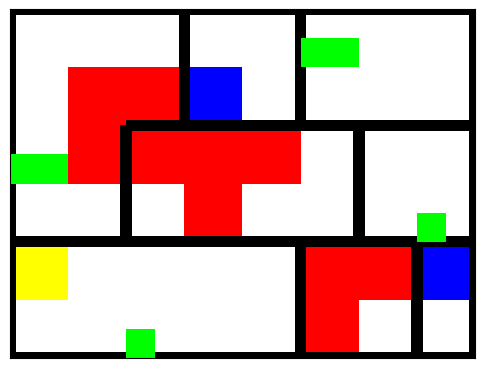

In [8]:
fig, axs = plt.subplots(figsize=(6,6))
axs.set_xticks([])
axs.set_yticks([])

# Primer frame
patch = axs.imshow(all_grids.iloc[0, 0], origin="lower")

def animate(i):
  patch.set_data(all_grids.iloc[i, 0])
  return [patch]

anim = animation.FuncAnimation(fig, animate, frames=len(all_grids), interval=200, blit=True)
plt.show()

In [9]:
anim